# Analysis of Enrollment Coach Impact On Persistence

At the start of the Spring 2025 semester, some approached me with questions about whether the students that were recruited under the new Enrollment Coach (EC) system had higher probabilities of persistence. That question led to this *causal inference* analysis. I unpack more below of what a Differenc-in-Differences (DiD) analysis is. Here, I will just highlight what a causal inference analysis is. This type of analysis can reliably uncover whether there is a **causal effect** for an intervention or treatment. In this case, we do so by comparing changes over time between the treatment group and the control group. Causal inference mimics experimental design, accounts for unobserved, time-invariant confounders, removes bias from factors that are constant over time, and controls for external factors that affect both groups equally, such as economic shifts, policy changes, etc. 

## The Data

The data for this analysis is the **<u>official IR, 20th Day data</u>** pulled from their database. When measuring persistence or retention, this is the best data to use due to the massive amount of changes in schedules between Day One and 20th day. Depending on the semester, this institution will typically see between 400 - 650 *total withdrawals*, the majority of which happen within the first two weeks of the semester. A total withdrawal is when a student drops all classes in which they were enrolled for the semester. When this is the case, the student completely drops out of circulation. So pulling Day One numbers and using those for this analysis would be incredibly misleading. Moreover, state reporting uses our 20th Day numbers and not our Day One numbers. 

The data includes every Fall and Spring semester from Fall 2012 to Spring 2025. The credit hour census data is used here because it is more complete. From the credit hour data, it is easy to create the headcount data in tandem, because that simply involves isolating the unique IDs from each semester. 

### Variables and Response

**Variables**

<u>*totcr*</u>: Number of credit hours attempted by each student each semester, recorded as a float variable.<br>
<u>*age*</u>: Age of student, recorded as an integer.<br>
<u>*gender*</u>: Self-identified gender of student.<br>
<u>*ethn_desc*</u>: Self-identified ethnicity of student.<br>
<u>*stype*</u>: The type of student for each semester (New, Transfer, Guest, High School, Continuing).<br>
- New: New students only have this label for their first semester, after which they are switched to "Continuing."
- Transfer: Transfer students receive this designation when they are transferring from another college or university to Bulter. Importantly, students self-select this designation when applying. Transfer students are swiched over to "Continuing" students after their first semester.
- High School: High school students receive this designation from the college. They remain high school students throughout their high school career no matter how many semesters they attend here during high school. If a student matriculates to this institution after high school, that student will then become a "New Student," then a "Continuing" student after their first semester out of high school.
- Guest: Guest students are students who attend a different community college or university and intend to take only a few classes from here to transfer back to their home institutions. They are not eligible for financial aid and cannot be degree seeking. These students select this designation when they apply.

<u>*ec_stud* (**the treatment group**)</u>: These are the Enrollment Coach students (EC); i.e. they are in an EC major and are New or Transfer based on their student type.<br>
<u>*post*</u>: Indicator variable that identifies the periods before intervention and after intervention.<br>
<u>*DiD*</u>: This is the interaction term between the treatment and the post period in which the intervention occurred. <br>

**Response**

<u>*persisted*</u>: Designates whether the student reenrolled the following semester or not (1 = persisted, 0 = did not persist). "Following semester" is the Spring semester directly after a Fall semester and the Fall semester directly after a Spring semester. 

In [1]:
import pandas as pd
import numpy as np

import math
from pathlib import Path

from src.pre_processing import (
    convert_csv_to_parquet, 
    isolate_fall_spring_persistence, 
    create_crhr_range)

import warnings
warnings.filterwarnings('ignore')

# Create root path to data
DATA_PATH = Path.cwd()/'Data'

# Load credit hour data
census_file = (pd.read_parquet(f'{DATA_PATH}/20th_D CrHr Enrollment 201280 - 202510.parquet')
                 .sort_values(['term', 'id'], ascending = [True, True])
                 .reset_index(drop = True)
              )

# Import major codes
majors = (pd.read_csv(DATA_PATH.parents[1]/'Fall and Spring Dashboards/Data/Major Descriptions.csv')
            .rename(columns = str.lower)
         )

# Make major dictionary 
majors = dict(zip(list(majors['majr_desc']), list(majors['majr'])))

# Create majr column
census_file['majr'] = [majors.get(majr) for majr in census_file['majr_desc1']]

# Reorient columns in census file
census_file = census_file[['id', 'term', 'purchase rate', 'first semester (join date)',
        'age by semester', 'age', 'age_range', 'totcr', 'status', 'stype',
        'resd_desc', 'degree', 'majr', 'majr_desc1', 'gender', 'mrtl', 'ethn_desc',
        'cnty_desc1', 'prevhrs', 'pt', 'loc', 'crn', 'sub', 'crs', 'title',
        'cr', 're', 'div', 'crs cd']]

# Add credit hour range column
census_file = create_crhr_range(census_file, 'totcr')

# Create headcount dataframe
headcount = (census_file
                .groupby(['term', 'id'], as_index = False).first()
                .reset_index(drop = True)
            )

# List of majors from enrollment coaches
coach_majors = ['BUAD', 'ACCT', 'BAAC', 'CLAR', 'IADF', 'INDP', 'IN3D', 'MRKT', 'ART',
                'AGBU', 'AGRI', 'ANSC', 'FRMG', 'AGFT', 'AGFB', 'AUTE', 'BUOM', 'CNST',
                'DITC', 'EMT', 'AEMT', 'FRSC', 'MCJR', 'MCMP', 'MCSM', 'MUSI', 'MUED',
                'THEA', 'WELD',
                # These below were added in SP25
                #'EACH', 'ECBA', 'EECU', 'ELEM', 'PSYC', 'SEED', 'SELA', 
                #'SEMA', 'SESC', 'SESS', 'SOSW', 'CMA', 'CNA', 'FITN', 'NUTI', 'OTA', 
                #'PRNU', 'PRPT', 'PPHA', 'PRPA', 'PRHS', 'MEDI', 'SMGT', 'BSBC'
               ]

# Student types for ECs
student_types = ['N', 'T']

## Calculating Persistence

*Persistence*, in this case, refers to the proportion of students from one semester that reenroll in the following semester. Colleges only track persistence from Fall to Spring and Spring to Fall. We do not include Summer terms as part of persistence. So the simple equation for persistence is:

$$\text{Persistence} = \frac{\text{Number Enrolled In Current Semester From Previous Semester}}{\text{Total Number Enrolled In Previous Semester}}$$

For instance, in Fall 2012, we had 9951 students enrolled in the college. The following semester, Spring 2013, 6560 from Fall 2012 enrolled. Therefore:

$$\text{Persistence} = \frac{6560}{9951} = 0.659230$$

Which means that 65.92% of the students from Fall 2012 persisted to Spring 2013. This same calculation applies when examining Spring to Fall. The proportion of students from Spring enrolled in the following Fall. 

In [2]:
# Create df to be used for previous semester
previous_term = (headcount
                    #.query("stype in ['N', 'T']")
                    #.query("majr in @coach_majors")
                    .reset_index(drop = True)
                   )

# Make dynamic term identifier
terms = previous_term['term'].unique()

# Loop through to calculate persistence
persistence = {}
persist = []

for term_num in range(1, len(terms)):
    # Store previous semester and current semester
    previous = previous_term[previous_term['term'] == terms[term_num - 1]]
    current = headcount[headcount['term'] == terms[term_num]]
    # Compare both semesters and save the students who made it from one to the next (i.e. persistence)
    combined = (previous.merge(current, on = 'id', how = 'left', indicator = True, suffixes =['', '_y'])
                     .pipe(lambda df: df.drop(columns = [c for c in df.columns if c.endswith('_y')]))
                     .query("_merge == 'both'")
                     .drop('_merge', axis = 1)
                )
    # Calculate persisence as a percentage of all students from the previous semester
    persistence[terms[term_num -1]] = len(combined)/len(previous)
    persist.append(combined)
    

### Evaluating Fall To Spring Persistence

The first table below shows the Fall to Spring persistence rates for each Fall semester dating back to 2012. This persistence reflects *all* students and not just a subsect of students like New and Transfer. So we see that the persistence rates have a small upward trajectory but not in any significant way. If we were to just use the average of the last four years (202180 - 202480), we could get within 0.50% of the actual persistence for Fall 2025 to Spring 2026, which demonstrates its stability.

### Overall Persistence

**Fall**

The Fall persistence over the last thirteen years falls between 64.18% (FA19) at its lowest to 68.81% (FA24) at its highest. In a separate analysis that is forthcoming, I completed a *Fixed Effects Model* on the enrollment data for Fall semesters, specifically examining economic drivers and their impact on enrollment. Long story short, the 18 month rolling, cumulative inflation, local area unemployment statistic (LAUS), and real wage growth were the primary drivers that boosted enrollment in Fall 2024, not anything we did as a college, unfortunately. 

Why is this important? Because when you look at the table below that shows the last thirteen years of Fall persistence data, one might be tempted to note that the highest persistence is Fall 2024 and conclude it must be from something we are doing. While I wish it were true, the statistical analysis simply does not bear that out. The reality is that this reflects the economic factors driving both enrollment *and* persistence. From January of 2021 to January of 2024, Americans experienced the highest inflation since 1981. Thus, inflation has rarely had a material impact on enrollment at colleges because the Fed's goal is to keep it around 2%. It peaked at 9.1% (YoY) in 2022. 

The following few outputs were muted due to the information they reveal. While colleges and universities have to report 20th day numbers to the Board of Regents and those numbers are posted on their website, the persistence rates are not reported or published. Similarly, retention numbers are posted and available to the outside world but persistence numbers are not.

In [3]:
isolate_fall_spring_persistence(persist, headcount, 'Fall').head(0)

,term,persistence,tot_hc,persist_percent,semester


**Spring**

Spring persistence has ranged between 49.57% and 52.33%, with an average of 50.43%, over the last thirteen years. It is amazingly stable. The lowest Spring to Fall persistence occurred between Spring 2014 and Fall 2014. The highest Spring to Fall persistence occurred between Spring 2017 and Fall 2017. The last three Spring to Fall semesters have had amazingly consistent persistence&mdash;50.35%, 50.31%, and 50.86%, respectively. 

In [4]:
isolate_fall_spring_persistence(persist, headcount, 'Spring').head(0)

,term,persistence,tot_hc,persist_percent,semester


### Data Imputation

Of the `ethn_desc` values, 1.8% are missing. Consequently, a new class labeled *Missing* was added to account for these students. *Age* and *Gender* are missing $\frac{1}{1000}\text{th}$ and $\frac{3}{1000}\text{th}$ of a percent, respectively. These have been deleted as they have no material impact on the calculations. All together, there are 203494 observations here, spanning 13 years.

The `all_persistence` dataset is used for all regression analysis. This is where we incorporate the list of students who persisted from one semester to another, label the enrollment coach students (`ec_stud`), label the period before and after enrollment coaches (`post`), and create the `DiD` variable. Then we clean up the data as mentioned in the first paragraph of this section.

In [5]:
# make dataframe with all persistence (persisted = 1, did not persist = 0; ec student = 1, not ec student = 0; 
# post treatment = 1, pre-treatment = 0)
all_persistence = (headcount.merge(pd.concat(persist), on = ['id', 'term'], how = 'left', indicator = True, suffixes=['', '_y'])
    .pipe(lambda df: df.drop(columns = [c for c in df.columns if c.endswith('_y')]))
    .rename(columns = {'_merge':'persisted'})
    .assign(
        persisted = lambda df: [1 if i == 'both' else 0 for i in df['persisted']],
        ec_stud = lambda df: [1 if i in coach_majors and j in student_types else 0 for i, j in zip(df['majr'], df['stype'])],
        year = lambda df: [str(term)[:4] for term in df['term']],
        semester = lambda df: ['Fall' if str(term)[4:] == '80' else 'Spring' for term in df['term']],
        post = lambda df: [1 if term >= 202410 else 0 for term in df['term']],
        DiD = lambda df: df['ec_stud'] * df['post'],
        ethn_desc = lambda df: ['Missing' if i == None else i for i in df['ethn_desc']],
    )
    .query("ethn_desc != 'DO NOT USE - Hispanic'")
    .query("gender in ['F', 'M', 'N']")
    .query("age.notnull()")
    .query("term % 100 == 80")
    [['term', 'year', 'semester', 'id', 'age', 'gender', 'majr', 'ethn_desc', 'totcr', 'stype', 'DiD', 'ec_stud', 'persisted', 'post']]
)

### Difference In Difference (DiD) and Multiple Logistic Regression

For the DiD setup, the model must include the treatment, which are the new and transfer students in the Enrollment Coach (EC) majors, post, which are the EC students from Fall 2024, and DiD, which is the interaction term of $\text{treatment} * \text{post}$. In this case, *treatment* is the students who are enrolled in the Enrollment Coach majors and are New or Transfer students (i.e. `ec_stud`). 

Unfortunately, there is no reliable tracking system to differentiate between students who enrolled *because* they engaged with an enrollment coach and those who fit all the criteria (EC major and New or Transfer) but enrolled *despite* an EC reaching out. The blanket assumption that a student enrolled because they received an email, text, or phone call from an EC is problematic. It disregards students who would have enrolled regardless and, in doing so, risks overestimating the effect of EC outreach. Indeed, the ECs themselves acknowledge that some students they contact never respond but later enroll on their own.

A well constructed DiD analysis typically includes a counterfactual group within the post period (i.e. students who resemble the treated group but did not receive treatment). Such students certainly exist within this cohort; we just lack a reliable way to separate them out. This creates an ambiguous treatment assignment problem: some students labeled as "treated" may not have been influenced by an EC at all, while some labeled as "untreated" may have indirectly benefited from EC outreach (e.g., hearing about it through peers). The latter of which is known as *treatment spillover*. Both issues introduce bias into the estimated treatment effect.

To improve future analyses, I recommend that ECs systematically record which students they have <u>**verifiable**</u> back-and-forth interactions with. Students who receive only an initial outreach attempt but do not engage in a meaningful conversation should not be classified as "EC students." Instead, they should fall into the "normal" group—students in EC majors who are New or Transfer but have no confirmed contact with an EC. This adjustment would create a more tenable classification system and reduce bias in future analyses.

#### Difference-in-Differences (DiD)

DiD is a quasi-experimental design method used to estimate the causal effect of an intervention (i.e. treatment) when random assignment is not feasible. In our case, students are self-selecting, which is a form of selection bias because it is possible that certain types of students with certain predispositions choose the Enrollment Coach (EC) majors. To carry out DiD, we compare changes over time between the treatment group EC majors, who are "New" or "Transfer" student types, and the control group. By tracking these groups over time, the statistical analysis can account for seasonal variances, natural ups and downs, in relation to the treatment group characteristics. The underlying idea is that both groups would have followed similar trends in the absence of the treatment; therefore, any change in their trends after the interevention can be attributed to the treatment itself. This method is illustrated in Figure 1.

<figure>
    <img src="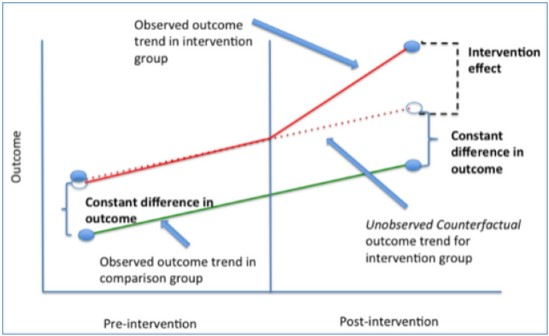 alt="Figure 1">
    <figcaption><em>Figure 1: Difference-in-Differences Graphical Representation</em> (cf: columbia.edu)</figcaption>
</figure>

**Before and After Comparison**

Here, we are looking at persistence, which is semester to semester enrollment, specifically Fall to Spring persistence, before and after the enrollment coach intervention. By comparing the difference in outcomes before and after the EC intervention with the treatment group and subtracting the corresponding change in the control group, you isolate the effect of the treatment from the other factors that might influence the outcome over time. 

**Mathematical Justification**

$$\text{DiD} = (\bar{Y}_{T=1,\text{Post}=1} - \bar{Y}_{T=1,\text{Post}=0}) - (\bar{Y}_{T=0,\text{Post}=1} - \bar{Y}_{T=0,\text{Post}=0})$$

Where:
- $Y_{it}$ is the outcome for individual $i$ at time $t$.
- $T_i$ is the *treatment* indicator. $T_i = 1$ if individual $i$ is in the treatment group and $T_i = 0$ if in the control group.
- $Post_i$ is the *time* indicator. Here $Post_i = 1$ for periods after the intervention and $Post_i = 0$ for periods before the intervention.

Thus:
- We calculate the change in outcome for the treatment group from before and after the intervention.
- Then calculate the change in the outcome for the control group over the same period.
- And finally calculate the *difference* between these two changes, which estimates the effect of the intervention.

For the purposes of this analysis, the DiD has been included into a `Multiple Logistic Regression` analysis.

$$Y_{it} = \beta_0 + \beta_1T_i + \beta_2\text{Post}_t + \beta_3(T_i * \text{Post}_t) + \sum_k \beta_{4k} \text{Ethnicity}_{ik} + \sum_j \beta_{5j} \text{StudentType}_{ij} + \beta_6(\text{Age}) + \beta_7(\text{TotalCreditHours}) + \epsilon_{it}$$

- $\beta_0$: Baseline outcome for the control group before the interventions (i.e. the intercept)
- $\beta_1$: Difference between the treatment and control groups before the intervention
- $\beta_2$: Change over time in the control group (i.e. the time trend)
- $\beta_3$: The <u>DiD estimator</u>. It captures the additional effect of the treatment after the intervention over and above the baseline differences and common time trends.
- $\beta_4$: The ethnicity of a student broken into dummy variables in relation to each level with K - 1 dummy variables (excluding the ref category).
- $\beta_5$: The student type of a student broken into dummy variables in relation to each level with K - 1 dummy variables (excluding the ref category).
- $\beta_6$: Age of student recorded as an integer.
- $\beta_7$: Total number of attempted credit hours each semester for the student.
- $\epsilon_{it}$: The error term

If $\beta_3$ is statistically significant, it implies that the treatment had a significant impact on the outcome and could not be attributed to some other cause or random chance. And the sign of the coefficient, positive or negative, indicates the direction of the effect. 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import statsmodels.api as sm
warnings.filterwarnings('ignore')

# Set reference level for stype (='N') and ethn (= 'Caucasian/White')
all_persistence['stype'] = pd.Categorical(all_persistence['stype'],
                                          categories = ['N', 'C', 'T', 'H', 'G', 'A'],
                                          ordered = True)

all_persistence['ethn_desc'] = pd.Categorical(all_persistence['ethn_desc'],
                                              categories = ['Caucasian/White', 'American Indian/Alaskan', 'Asian',
                                                            'Black', 'Hispanic', 'Missing', 'Mixed', 'Pacific Islander/Hawaiian',
                                                            'Undeclared'],
                                              ordered = True)

# Create dummy varibles
dummies = pd.get_dummies(
    all_persistence[['term', 'gender', 'ethn_desc', 'stype']],
    columns=['term', 'gender', 'ethn_desc', 'stype'],
    prefix={'term': 'term', 'gender': 'gender', 'ethn_desc': 'ethn_desc', 'stype': 'stype'},
    drop_first=True # Avoids multicollinearity
)

# Combine the DiD varibles with other features
features = ['DiD', 'ec_stud', 'post', 'totcr', 'age']
X = pd.concat([all_persistence[features], dummies], axis = 1)
y = all_persistence['persisted']

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Initialize and fit the logreg mod
lr_mod = LogisticRegression(max_iter = 1000)
lr_mod.fit(X_train, y_train)

# Make predictions on test set
y_pred = lr_mod.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Create confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate TPR
sensitivity = tp / (tp + fn)

# Calculate TNR
specificity = tn / (tn + fp)

(print(" Logistic Regression Evaluation Metrics:\n",
       "Accuracy:", round(accuracy, 4), '\n',
       "Sensitivity:", round(sensitivity, 4), '\n\n',
       "Logistic Regression Results\n",
       "   Dep. Variable: Persisted\n",
       "   Model:             Logit\n",
       "   Method:              MLE\n",
       "   Converged:          True\n",
       "   LLR p-value:       0.000\n"))

# ---------------------------------------------------------
#                   Evaluate DiD
# Run inferential statistics for log reg model via the 
# statsmodels library
# ---------------------------------------------------------

# The statsmodels provides a more detailed output of the coefficients, for instance, providing
# p-values of the variables. Therefore, I ran it specifically for the interpretation of the
# model output.
# Add intercept to the model
X_sm = sm.add_constant(X.drop(columns = ['term_202480']))

# Convert any boolean columns in X_sm to integer type
X_sm = X_sm.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)

# Fit the logistic regression model
logit_model = sm.Logit(y, X_sm) 
result = logit_model.fit_regularized(alpha = 1e-6, maxiter = 1000, trim_mode='size', disp = False)

# Control the formatting of the table since I am accessing just the 
# coefficient table
def format_numeric(x):
    try:
        return "{:.3f}".format(float(x))
    except (ValueError, TypeError):
        return x

# View coefficient table
(result.summary2().tables[1].applymap(format_numeric)
     .reset_index()
     .rename(columns = {'index':'Variables'})
     .query("Variables in ['const', 'DiD', 'ec_stud', 'post', 'totcr', 'age',\
            'gender_M', 'ethn_desc_American Indian/Alaskan', 'ethn_desc_Asian',\
            'ethn_desc_Black', 'ethn_desc_Hispanic', 'ethn_desc_Missing', 'ethn_desc_Mixed',\
            'ethn_desc_Pacific Islander/Hawaiian', 'ethn_desc_Undeclared', 'stype_C',\
            'stype_T', 'stype_H', 'stype_G']")
     .reset_index(drop = True)
)

 Logistic Regression Evaluation Metrics:
 Accuracy: 0.7048 
 Sensitivity: 0.8913 

 Logistic Regression Results
    Dep. Variable: Persisted
    Model:             Logit
    Method:              MLE
    Converged:          True
    LLR p-value:       0.000



,Variables,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
0,const,-1.056,0.043,-24.832,0.000,-1.139,-0.973
1,DiD,-0.014,0.113,-0.128,0.898,-0.235,0.206
2,ec_stud,-0.014,0.035,-0.389,0.697,-0.082,0.055
3,post,0.036,0.037,0.968,0.333,-0.036,0.108
4,totcr,0.171,0.002,90.857,0.000,0.168,0.175
5,age,0.011,0.001,11.681,0.000,0.009,0.013
6,gender_M,-0.166,0.014,-11.708,0.000,-0.194,-0.138
7,ethn_desc_American Indian/Alaskan,-0.125,0.066,-1.901,0.057,-0.254,0.004
8,ethn_desc_Asian,0.006,0.032,0.188,0.851,-0.058,0.070
9,ethn_desc_Black,-0.278,0.024,-11.372,0.000,-0.326,-0.230


### Evaluation of Logistic Regression Analysis

**Setting Reference Levels**

For student type, I set the reference level to "New Student" and ethnicity is set to "Caucasian/White." Thus, all the Odds Ratios (OR) are in reference to those. This is also a good time to say, in any type of multiple regression analysis like this one, the assumption is always, "all other variables held constant." I will not state this before every discussion of every feature. Rather, it is expected that the reader understands this. Thus, we might say, "On average, with all other variables held constant, the odds a Continuing student will persist are _____ when compared to New Students." Nevertheless, this does not mean that the other variables have no material impact. They indeed do. The coefficients for the variables would change if some of these features were left out or if new ones were added in. The influence of the variables is baked into the coefficient of each. These coefficients represent the unique contribution of each variable to the model *given* the presence of the other variables.

**Difference-in-Differences (`DiD`)**

The important coefficients in this analysis are the ones pertaining to the `DiD`, `post`, and `ec_stud` variables. The most important coefficient we are interested in is the `DiD` varible, because it is measuring the effect of the intervention. First, we notice that at an $\alpha$-value of 0.01, it is *not statisitcally significant* ($p = 0.898$), which is to say, we cannot confidently say that the observed difference is not due to random chance or other factors rather than the intervention itself. Based on the coefficient of the `DiD`, when a student is New or Transfer and in a Major assisted by enrollment coaches in the periods in which they have been active, the odds that student persists slightly **decreases** by a marginal and non-statistically significant -1.4% ($e^{-0.014} = 0.986\rightarrow(0.986 - 1) \times 100 = -1.4\%$).

**Enrollment Coach Majors (`ec_stud`)**

Students who are New or Transfer student types and enrolled in one of the Enrollment Coach majors during any academic term (i.e. in periods preceding academic coaches) see a 1.4% decrease in the odds of persistence from Fall to Spring without any coach intervention, but the effect is **statistically insignificant** ($p = 0.697$).

**Number of Credit Hours Per Semester**

The number of credit hours a student is taking during a semester, denoted as `totcr` *is* a statistically significant predictor at an $\alpha$-value of 0.01 with a p-value of 0.001. For each additional credit hour that a student takes during a semester, the odds a student persists increases by 18.65%. Remember, in logistic regression, the coefficient is on a log odds scale, which means that the effect of each unit increase is multiplicative rather than just additive. I say this so that someone does not misapply this to say, "If a student takes 15 credits, then they are 279.75% more likely to persist from one semester to another," which would be the result if you multipled 18.65% by 15 ($18.65 * 15 = 279.75$). Rather, each additional unit increase *multiplies the odds*, which are denoted by the coefficient 0.171. So to calculate the odds a student persists who takes 15 credits, we would do it this way:

$$\text{Odds Ratio} = e^{(15 * 0.171)} = e^{2.57}$$

Then we exponentiate that result

$$\text{Odds Ratio} = e^{2.57} = 13.00$$

Which means the odds a student persists from one semester to another increases by 1200% when they take 15 credits versus when they take zero. However, students do not take zero credits so this is not a good baseline. 

Since students do not take zero credits, we can use the coefficient to calculate the *relative odds* given a certain number of credit hours. To compare a student taking 15 credits versus a student taking 6, we compute the difference. 

$$e^{((15 - 6) * 0.171)} = 4.66$$

Thus, the odds a student persists from one semester to another taking 15 credits is 4.66 times the odds of a student who takes 6 credits. Put another way, the odds of persistence are 366% higher relative to the 6 credit hour courseload. Now, the average number of credits a student takes in any given semester (averaged from 20th day data from 201280 to present) is 9.31 credits. The odds a student persists who takes 15 credits are 2.65 times higher than a student who takes the average number of credits. 

Table 1 below shows the percentage of students who have taken the number of credit hours listed in each row. We see that, on average, since Fall 2012, about 24.41% of students enrolled in any given semester have taken 12 - 14 credit hours and **60.68%** of students take 11 credits or fewer each semester. 

<div style="float: left;">
    <em>Table 1: Number of credits per student</em> 
    <table>
        <thead>
            <tr>
                <th>Credit_Range</th>
                <th>Count</th>
                <th>Percentage</th>
            </tr>
        </thead>
        <tbody>
            <tr><td>0 - 5</td><td>28248</td><td>0.229915</td></tr>
            <tr><td>6 - 8</td><td>25833</td><td>0.210259</td></tr>
            <tr><td>9 - 11</td><td>20468</td><td>0.166592</td></tr>
            <tr><td>12 - 14</td><td>29989</td><td>0.244085</td></tr>
            <tr><td>15 - 17</td><td>13475</td><td>0.109675</td></tr>
            <tr><td>18 - 20</td><td>3440</td><td>0.027999</td></tr>
            <tr><td>21 - 23</td><td>531</td><td>0.004322</td></tr>
            <tr><td>24 - 26</td><td>164</td><td>0.001335</td></tr>
            <tr><td>>= 27</td><td>715</td><td>0.005819</td></tr>
        </tbody>
    </table>
</div>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

**What Does This Tell Us?**

We have to be careful how we interpret this. Two years ago, at the *Ad Astra* national conference, they presented similar findings from a larger cohort and then labeled this *academic momentum*, stating that if colleges and universities want students to persist at higher levels, we should be encouraging students to enroll in more credit hours. After all, more credits provides statistically significant higher odds that a student will persist. **Not so fast!** Their conclusion was erronious, because they applied a *cause* where it was merely a *correlation*.

In reality, students at this institution that are enrolled in more than the average, that 40% here that are enrolled in 12 or more credits, have a myriad of other characteristics that are more explanatory. In other words, there are confounding variables that better explain why students who attempt more credits per semester tend to persist at higher rates. The `totcr` varible is actually a proxy for several other charcteristics of students. These students are far more likely to be on scholarship, either fine arts scholarships (i.e. music scholarships of whatever flavor) or athletic scholarships. Consequently, they are *required* to be enrolled in *at least* 12 credits. Most will be in far more than 12. Second, students enrolled in 12 or more credits will overwhelmingly be 18 - 20 years old and in stages of life in which outside commitments are relatively low. Therefore, they can handle&mdash;and pass&mdash;more credits. These students are more likely to be VA, TAA, WIA, or TA students. Some of these require students to be in 12 credits. Others do not require it but the student benefits if they are in 12 or more. 

Therefore, it *should not* become the policy of this institution that, because we know students who attempt more credits each semester have higher odds of persistence, we put more students in more credits. Rather, this logistic regression model shows that if we wanted to predict which students are more likely to persist from one semester to another, and we only have access to the predictors we used here, that `totcr` is a great perdictor because of the characteristics it embodies about the student. 

**Evaluation of Student Type Feature**

<div style="float: left;">
    <em>Table 2: Odds Of Persistence Based On Student Type</em> 
    <table>
        <thead>
            <tr>
                <th>Stype</th>
                <th>Odds Ratio (OR)</th>
                <th>p-value</th>
            </tr>
        </thead>
        <tbody>
            <tr><td>C</td><td>-6.574%</td><td>0.001</td>
            <tr><td>T</td><td>-27.675%</td><td>0.001</td>
            <tr><td>H</td><td>225.112%</td><td>0.001</td>
            <tr><td>G</td><td>-64.442%</td><td>0.001</td>
        </tbody>
    </table>
</div>
<br><br><br><br><br><br><br><br><br><br>

Table 2 shows the odds a student persists from Fall to Spring, all else held constant, compared to the reference group of "New Students (N)". All of the student type preditors were statistically significant at an $\alpha$-value of 0.01. They all shared the p-value of 0.001. The odds a student who is a continuing student persists are 6.57% lower compared to new students. This means, in any given Fall to Spring persistence, just by virtue of being a New Student, those students will persist at higher rates. If we only know a student's student type is "New," we can predict with about 72% accuracy, that the student will persist from Fall to Spring, whereas only about 64% of continuing students persist from Fall to Spring. If a student is a Transfer student, the odds that student persists are 27.68% lower than a student who is a New Student. The only student type that has far *greater* odds of persistence from Fall to Spring over New Students is the High School student type. The odds these students persist from Fall to Spring are 225.11% higher than those that are New Students. Finally, the odds a Guest Student persists are 64.44% lower than that of a New Student.

**Evaluation of Gender**

The odds a male student persists is 15.30% lower than that of a female student. Other recorded genders did not have statistically significant p-values. 

**Evaluation of Ethnicity**

<div style="float: left;">
    <em>Table 3: Odds Of Persistence Based On Ethnicity</em> 
    <table>
        <thead>
            <tr>
                <th>Ethnicity</th>
                <th>Odds Ratio (OR)</th>
                <th>p-value</th>
            </tr>
        </thead>
        <tbody>
            <tr><td>Black</td><td>-24.270%</td><td>0.001</td>
            <tr><td>Hispanic</td><td>-5.067%</td><td>0.014</td>
            <tr><td>Mixed</td><td>-20.626%</td><td>0.001</td>
        </tbody>
    </table>
</div>
<br><br><br><br><br><br><br><br>

The reference group for ethnicity is "Caucasian/White". There were three different ethnicities that had statistically significant p-values at an $\alpha$-value of 0.05&mdash;Black, Hispanic, and Mixed. These are self-determined ethnicities entered by the student in reference to themselves. Since these are statistically significant, we can safely conclude that the ethnicity of the student in these specific cases is predictive of whether that student persists in relation to the reference group. The odds a Black student persists is 24.27% lower than that of a White student. The odds a Hispanic student persists is 5.067% lower than that of a White student. And the odds a student of Mixed race persists are 20.63% lower than that of a White student. 

#### Logistic Regression Evaluation Metrics

The logistic regression model was particularly good at identifying students who have the highest odds of persistence, which is the metric we care most about. In this case, the model correctly identifies students who have the highest odds of persistence with a *sensitivity* of about 88%. There is certainly room for improvement. If we were attempting to launch this model into production, I would seek out more predictors and do more feature engineering. Other models I have created for the college correctly identify these students 91% of the time but have more predictors and use a model that is not as interpretable (i.e. XGBoost). Since, for this analysis, we needed interpretability, I went with a logistic regression model. The model is a statistically significant model, and the overall fit is acceptable.

To establish the validity of the model, several standard tests were ran. I looked at the Variance Inflation Factor to check for multicollinearity, looked at the influence diagnostics, examined the deviance residuals, applied the Hosmer-Lemeshow test to check for model calibration. All had acceptable results to move forward with the analysis.

## Conclusions

Based on a robust Difference-in-Differences analysis with a large sample size, there is no statistically significant evidence that the intervention from the ECs had any effect on student persistence. The results hold across multiple significance thresholds ($\alpha$ = 0.01, $\alpha$ = 0.05, $\alpha$ = 0.10), and parallel trends were confirmed before and after treatment. Additionally, variance inflation factor (VIF) analysis did not indicate significant multicollinearity or confounding. Given these findings, the most likely explanation is that the intervention simply did not have a measurable impact on student persistence.

As mentioned earlier, if we are serious about wanting to evaluate the effectiveness or our methods, we need a better tracking system for the EC students. My proposed method mentioned earlier is to only count students with verified interactions as EC students. A student who simply enters the funnel but never responds to a single text, phone call, or email and yet still gets enrolled should not be counted as an EC student. **Moreover**, we should not attempt to cook the books by then forcing all of these students to go through enrollment coaches if they do come in on their own. This would, again, bias the data and nullify a robust analysis of the new EC methods.

## Appendix

The first table displayed below is just the output of the code in the cell below. I include this here for transparency so that the reader knows how Table 1 in the main body of the article was created. 

In [7]:
# Create pivot table of individual semester enrollment patterns
pivot_table = (census_file
   .groupby(['term', 'id', 'credit_range'], as_index=False)['id'].first()
   .groupby(['term', 'credit_range'], as_index=False)['id'].count()
   .rename(columns = {'id':'cnt'})
   .sort_values(['term', 'credit_range'])
   .pivot_table(index = 'term', columns = 'credit_range', values = 'cnt')
)

# Reorder columns numerically
sorted_columns = sorted(pivot_table.columns, key=lambda x: float(x.split()[0]) if x[0].isdigit() else float('inf'))
pivot_table = pivot_table[sorted_columns]

# Create percentage of credits enrolled in
pivot_table_percentage = round(pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100, 2)

# Create a pivot table with all semesters combined
(census_file
   .groupby(['id', 'credit_range'], as_index=False)['id'].first()
   .groupby(['credit_range'], as_index=False)['id'].count()
   .rename(columns={'id': 'count'})
   .assign(
       percentage=lambda df: df['count'] / df['count'].sum(),
       sort_key=lambda df: df['credit_range'].apply(lambda x: float(x.split()[0]) if x.split()[0].isdigit() else float('inf'))
   )
   .sort_values('sort_key')
   .drop(columns=['sort_key'])
).head(0)

,credit_range,count,percentage


**Percentage of Credit Hours Attempted Every Semester**

Earlier in the report, we looked at the *average* number of credits attempted every semester by students over the last thirteen years. This table below shows the individual semeseter breakdown just so the reader can understand how stable the percentages are. 

Keep in mind, you should compare Fall semesters with Fall semesters and Spring semesters with Spring semesters. Remember, semesters ending with "80" are Fall semesters and semesters ending with "10" are Spring semesters. 

In [8]:
pivot_table_percentage.head(0)

credit_range,0 - 5,6 - 8,9 - 11,12 - 14,15 - 17,18 - 20,21 - 23,24 - 26,>= 27
term,,,,,,,,,
